# Cassava Leaf Classification | Artificial Intelligence

Background and Motivation
One of Africa’s most crucial staple crops, the starchy cassava plant is the second-largest producer of carbohydrates on the entire continent, and, while this plant is known for its hearty nature and ability to withstand harsh environmental conditions, rampant disease outbreaks often threaten crop yields and pose a serious threat to the subsistence farmers who grow them. While over 80% of small, household farms in Sub-Saharan Africa grow this root, few have the ability to detect and mitigate the devastating effects of disease outbreaks with which they are regularly plagued. At present, in order to assess whether one’s plants are stricken with disease, farmers must work with local government officials to deploy agricultural experts to inspect the plants in person. Unfortunately, this process is extremely labor intensive, slow, and inefficient which puts farmers at greater risk for losing larger portions of their harvest if they are indeed dealing with an outbreak amongst their plants. In order to help speed up this process and provide farmers with the best opportunity to save their crops, it is our goal to help develop a convolutional neural network which will be able to quickly and accurately classify whether a given plant is suffering from a disease or not by simply providing the model with an image of that plant’s leaves. Given that many cameras the local farmers have access to may be quite low quality, we will be using representative photographs to train our model and will try to create a solution that will be robust in its effectiveness and able to perform for all those who so desperately need it.


## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from keras.preprocessing import image
from tensorflow.python.profiler import profiler_client



In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Loading Data

In [ ]:
# from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/ColabNotebooks/


/content/drive/MyDrive/ColabNotebooks


In [ ]:
train_names = pd.read_csv('train.csv')

In [ ]:
train_names['label'] = train_names['label'].apply(str)
train_names.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [ ]:
print(len(train_names))

21397


The dataset we are provided with to create and optimize our network with contains 21,397 observations of cassava leaf images and their corresponding disease classifications. The five categories that the leaf images fall under are Cassava Bacterial Blight (CBB), Cassava Brown Streak Disease (CBSD), Cassava Green Mottle (CGM), Cassava Mosaic Disease (CMD), and Healthy. Some example images of these are shown below.

Upon running the value_counts function on our data frame of class labels, we got the output shown below.


In [ ]:
train_names['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

While this is not a particularly in-depth analysis, it does provide us with some valuable insights that will help us establish our majority classifier below. We can see that, while most of the classes such as CBSD, CGM, and Healthy have between 2100 and 2600 images for each of them, there are over 13000 images of CMD stricken cassava plants which accounts for nearly 61.5% of our entire set of training data. While this could be the result of some less than perfect sampling to create the training set, it is reasonable to assume the more likely scenario that CMD is by far the most common condition, and should allow us to create a very naive baseline model that simply classifies all images as being afflicted with it. This approach is not the most informative, but it does provide a base level accuracy which we know we must improve upon if we hope to be of any utility to the people struggling to find a solution to these very real and vital agricultural problems.

## Plot the Data

The shape of the images is: (600, 800, 3)


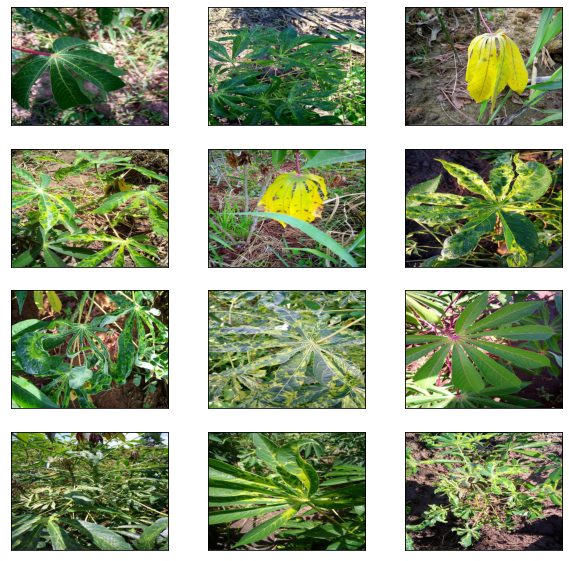

In [ ]:
plt.figure(figsize =(10,10),num=0)
for i,filename in enumerate(glob.iglob('/content/drive/My Drive/ColabNotebooks/train_images' + '**/*.jpg', recursive = True)):
    if i ==12:
        image = Image.open(filename)
        image_shape = np.array(image).shape
        print("The shape of the images is: {}".format(image_shape))
        break
    elif i<12:
        img = mpimg.imread(filename) # reading the image from the jpg files into an array.
        plt.subplot(4,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img)# displaying the data as an image
plt.show()        

In [ ]:
batch_size = 32
# img_height = image_shape[0]
# img_width = image_shape[1]
img_height = int(image_shape[0]/6)
img_width  = int(image_shape[1]/6)
print(img_height,img_width)

100 133


## Data PreProcessing

In [ ]:
# Performing on the fly image augmentation
train_datagen = ImageDataGenerator(rescale=1./255.,shear_range=0.2,
        zoom_range=0.2,
        featurewise_center = True,
        samplewise_center = True,
        zca_whitening = True,
        rotation_range =45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        vertical_flip = True,horizontal_flip=True, validation_split=0.2)



We've applied feature scaling,image augmentation and then split the train set into 2 partitions one for training and the other for validation just by specifying the argument validation_split=0.2 which splits the dataset into to 2 sets where the validation set will have 20% of the total images.

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
dataframe = train_names,
directory = '/content/drive/My Drive/ColabNotebooks/train_images',
x_col = "image_id",
y_col = "label",
subset = "training",
batch_size = batch_size,
seed = 42,
shuffle = True,
class_mode = "sparse",
target_size = (img_height, img_width))

Found 17118 validated image filenames belonging to 5 classes.


In [ ]:
valid_generator = train_datagen.flow_from_dataframe(
dataframe = train_names,
directory = '/content/drive/My Drive/ColabNotebooks/train_images',
x_col = "image_id",
y_col = "label",
subset = "validation",
batch_size = batch_size,
seed =42,
shuffle = True,
class_mode ="sparse",
target_size = (img_height, img_width)
)

Found 4279 validated image filenames belonging to 5 classes.


## Iterating Over Data and Plotting it

## Now the data and labels are together!

In [ ]:
image_batch, labels_batch = next(iter(train_generator)) # getting a single batch from train generator
print(image_batch.shape)
print(labels_batch.shape)
print(labels_batch)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


(32, 100, 133, 3)
(32,)
[3. 3. 3. 4. 4. 3. 4. 3. 2. 3. 4. 2. 3. 0. 1. 3. 2. 3. 3. 3. 3. 2. 3. 0.
 3. 4. 3. 3. 4. 3. 3. 3.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

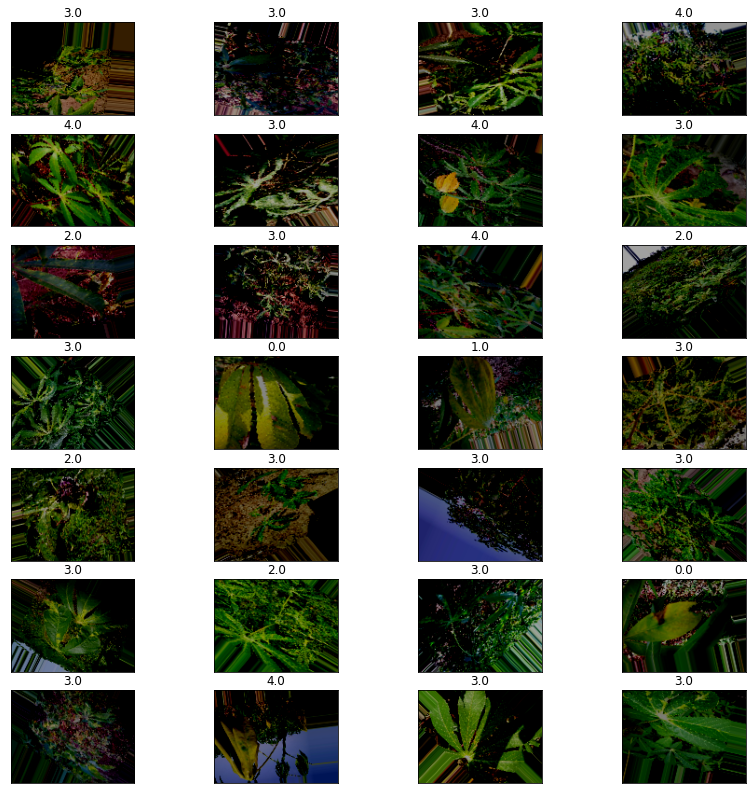

In [ ]:
plt.figure(figsize =(14,14),num=1)
for i in range(28):
    max_index =labels_batch[i]
    plt.subplot(7,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image_batch[i])
    plt.title(max_index)
plt.show()    

In [ ]:
image_batch, labels_batch = next(iter(valid_generator))
print(image_batch.shape)
print(labels_batch.shape)
print(labels_batch)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


(32, 100, 133, 3)
(32,)
[3. 3. 3. 2. 3. 2. 3. 3. 2. 3. 3. 3. 1. 3. 3. 3. 1. 3. 3. 2. 3. 3. 2. 1.
 3. 3. 3. 2. 4. 3. 2. 2.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

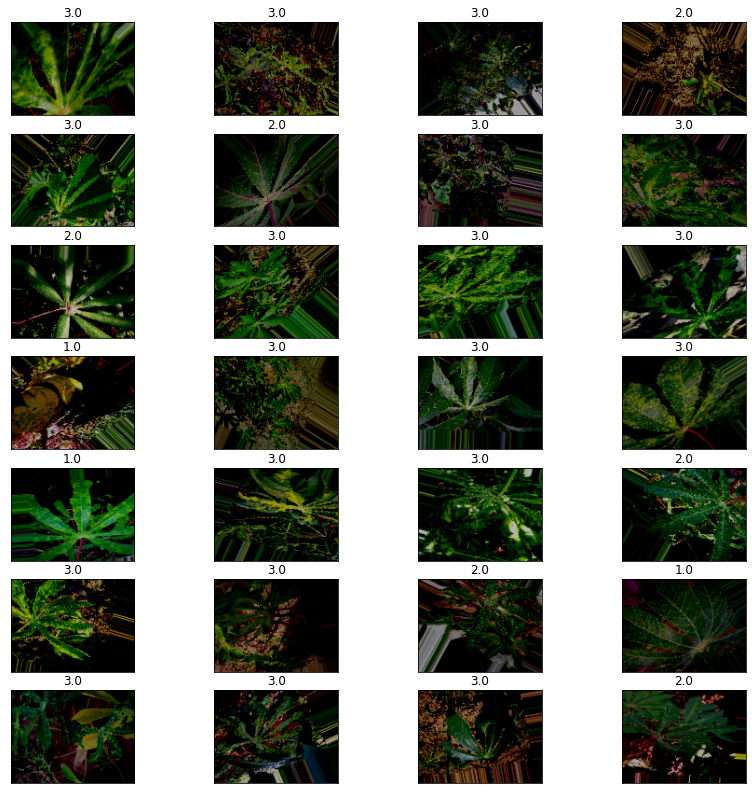

In [ ]:
plt.figure(figsize = (14,14),num=1)
for i in range(28):
    max_index = labels_batch[i]
    plt.subplot(7,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image_batch[i])
    plt.title(max_index)
plt.show()    

## Building the Model

In [ ]:
# Initializing the CNN
cnn = tf.keras.models.Sequential()

In [ ]:
# Adding the first Convolution layer
# Step1: Convolution
cnn.add(tf.keras.layers.Conv2D(filters = 96, kernel_size=11, activation ='relu', input_shape =(img_height, img_width,3)))

# Step2: Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides = 2))


In [ ]:
# Adding a second Convolution layer
cnn.add(tf.keras.layers.Conv2D(filters = 96, kernel_size=7, activation ='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides =2))

In [ ]:
# Adding a third Convolution layer
cnn.add(tf.keras.layers.Conv2D(filters = 192, kernel_size=5, activation ='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides = 2))

In [ ]:
# Adding a fourth Convolution layer
cnn.add(tf.keras.layers.Conv2D(filters = 192, kernel_size=3, activation ='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides = 2))

In [ ]:
# Adding a fifth Convolution layer
# cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size=3, activation ='relu'))
# cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides = 2))

In [ ]:
# Adding a sixth Convolution layer
# cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size=3, activation ='relu'))
# cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides = 2))

In [ ]:
# Step3: Flattening
cnn.add(tf.keras.layers.Flatten())

In [ ]:
# Step4: Full Connection
cnn.add(tf.keras.layers.Dense(units = 512, activation = 'relu'))

In [ ]:
# Adding another fully connected layer
cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))

In [ ]:
# dropout in hidden layers with weight constraint
cnn.add(tf.keras.layers.Dropout(0.2))

In [ ]:
# Adding another fully connected layer
cnn.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))

In [ ]:
# dropout in hidden layers with weight constraint
# cnn.add(tf.keras.layers.Dropout(0.2))

In [ ]:
# Adding another fully connected layer
# cnn.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))

In [ ]:
# Step5: Output Layer
cnn.add(tf.keras.layers.Dense(units=5, activation ='softmax'))

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 90, 123, 96)       34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 61, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 39, 55, 96)        451680    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 19, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 23, 192)       460992    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 11, 192)       0

## Training the CNN

In [ ]:
# compiling the CNN
cnn.compile(optimizer = 'adam',loss ='sparse_categorical_crossentropy', metrics=["accuracy"])

In [ ]:
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# # simple early stopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)

In [ ]:
# Training the CNN on the Training set and evaluating it on the Test set
history = cnn.fit(x = train_generator, validation_data = valid_generator, epochs = 100)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
535/535 [==============================] - 287s 532ms/step - loss: 1.1562 - accuracy: 0.6158 - val_loss: 1.2167 - val_accuracy: 0.5903
Epoch 2/100
535/535 [==============================] - 269s 503ms/step - loss: 1.0689 - accuracy: 0.6289 - val_loss: 1.0609 - val_accuracy: 0.6319
Epoch 3/100
535/535 [==============================] - 269s 503ms/step - loss: 1.0368 - accuracy: 0.6368 - val_loss: 1.0145 - val_accuracy: 0.6380
Epoch 4/100
535/535 [==============================] - 268s 501ms/step - loss: 1.0264 - accuracy: 0.6361 - val_loss: 1.0161 - val_accuracy: 0.6354
Epoch 5/100
535/535 [==============================] - 268s 502ms/step - loss: 1.0143 - accuracy: 0.6382 - val_loss: 1.0001 - val_accuracy: 0.6401
Epoch 6/100
535/535 [==============================] - 269s 502ms/step - loss: 1.0116 - accuracy: 0.6401 - val_loss: 0.9843 - val_accuracy: 0.6424
Epoch 7/100
535/535 [==============================] - 267s 499ms/step - loss: 1.0003 - accuracy: 0.6389 - val_loss: 0

The model performance is improved significantly.

In [ ]:
from sklearn.metrics import confusion_matrix
Y_pred = cnn.predict_generator(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_generator.classes, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Confusion Matrix
[[   8   27    8  139   18]
 [  24   49    8  317   38]
 [  22   66   14  354   39]
 [ 125  290   88 1868  267]
 [  27   33   19  372   59]]


In [ ]:
# Evaluating the model 
# loss_train = history.history['accuracy']
# loss_val = history.history['val_accuracy']
# epochs = range(1,16)
# plt.plot(epochs, loss_train, 'g', label='Training accuracy')
# plt.plot(epochs,loss_val, 'b', label='validation accuracy')
# plt.title('Training and Validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

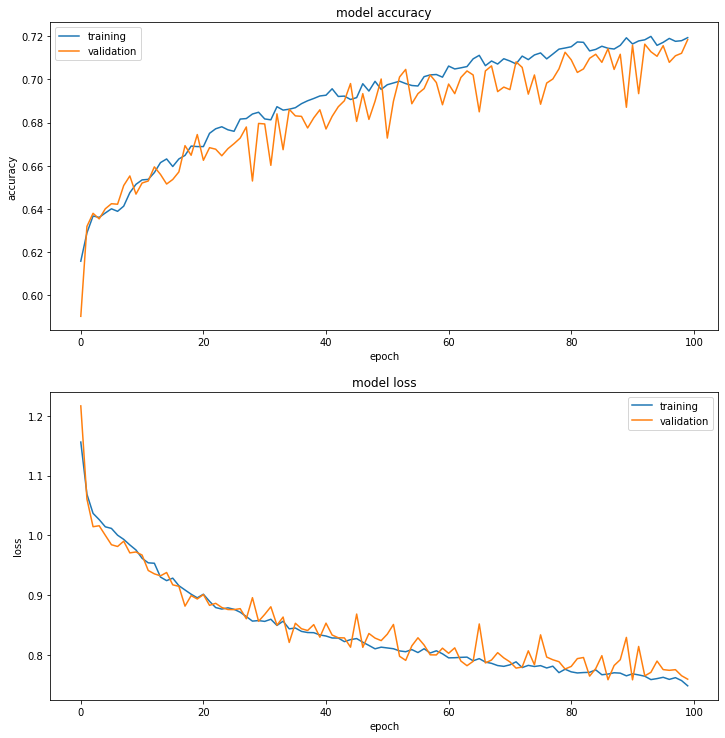

In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## Making a single Prediction

In [ ]:
from keras.preprocessing import image
test_image = image.load_img('/content/drive/My Drive/ColabNotebooks/test_images/2216849948.jpg', target_size = (img_height, img_width))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
train_generator.class_indices
if result[0][0] == 0:
    prediction = 'Cassava Bacterial Blight (CBB)'
elif result[0][0] == 1:
    prediction = 'Cassava Brown Streak Disease (CBSD)'   
elif result[0][0] == 2:
    prediction = 'Cassava Green Mottle (CGM)' 
elif result[0][0] == 3:
    prediction = 'Cassava Mosaic Disease (CMD)' 
elif result[0][0] == 4:
    prediction = 'Healthy'     
    

In [ ]:
print(prediction)

Cassava Bacterial Blight (CBB)


## Saving the Model

In [ ]:
tf.keras.models.save_model(cnn,'cnn_casava_leaves.hdf5')